In [ ]:
#| echo: false
%load_ext autoreload
%autoreload 2

# Sktime models
> Use any sktime forecaster for forecasting

statsforecast supports [sktime](https://github.com/sktime/sktime) forecasters through the `statsforecast.models.SktimeModel` wrapper. You can use Theta, ARIMA, ETS, and other sktime algorithms alongside native statsforecast models, with one model fit per series.

Install the optional dependency: `pip install statsforecast[sktime]` or `pip install sktime`.

## Data setup

Use the same data format as other statsforecast models: a dataframe with `unique_id`, `ds`, and `y`. Exogenous variables are optional and only needed for Section 2 (forecasters that support `X`).

In [1]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from utilsforecast.plotting import plot_series

from statsforecast import StatsForecast
from statsforecast.models import SktimeModel
from statsforecast.utils import ConformalIntervals

import pandas as pd
import numpy as np

In [2]:
np.random.seed(42)
n_series = 3
len_series = 72
dates = pd.date_range('2018-01-01', periods=len_series, freq='MS')
data = []
for i in range(n_series):
    y = 100 + np.cumsum(np.random.randn(len_series) * 2) + 10 * np.sin(np.arange(len_series) * 2 * np.pi / 12)
    data.append(pd.DataFrame({'unique_id': str(i), 'ds': dates, 'y': y}))
train = pd.concat(data, ignore_index=True)
train.head()

,unique_id,ds,y
0,0,2018-01-01,100.993428
1,0,2018-02-01,105.716900
2,0,2018-03-01,110.672531
3,0,2018-04-01,115.058336
4,0,2018-05-01,113.250284


## 1. ThetaForecaster and NaiveForecaster

Using sktime's ThetaForecaster and NaiveForecaster (no exogenous variables).

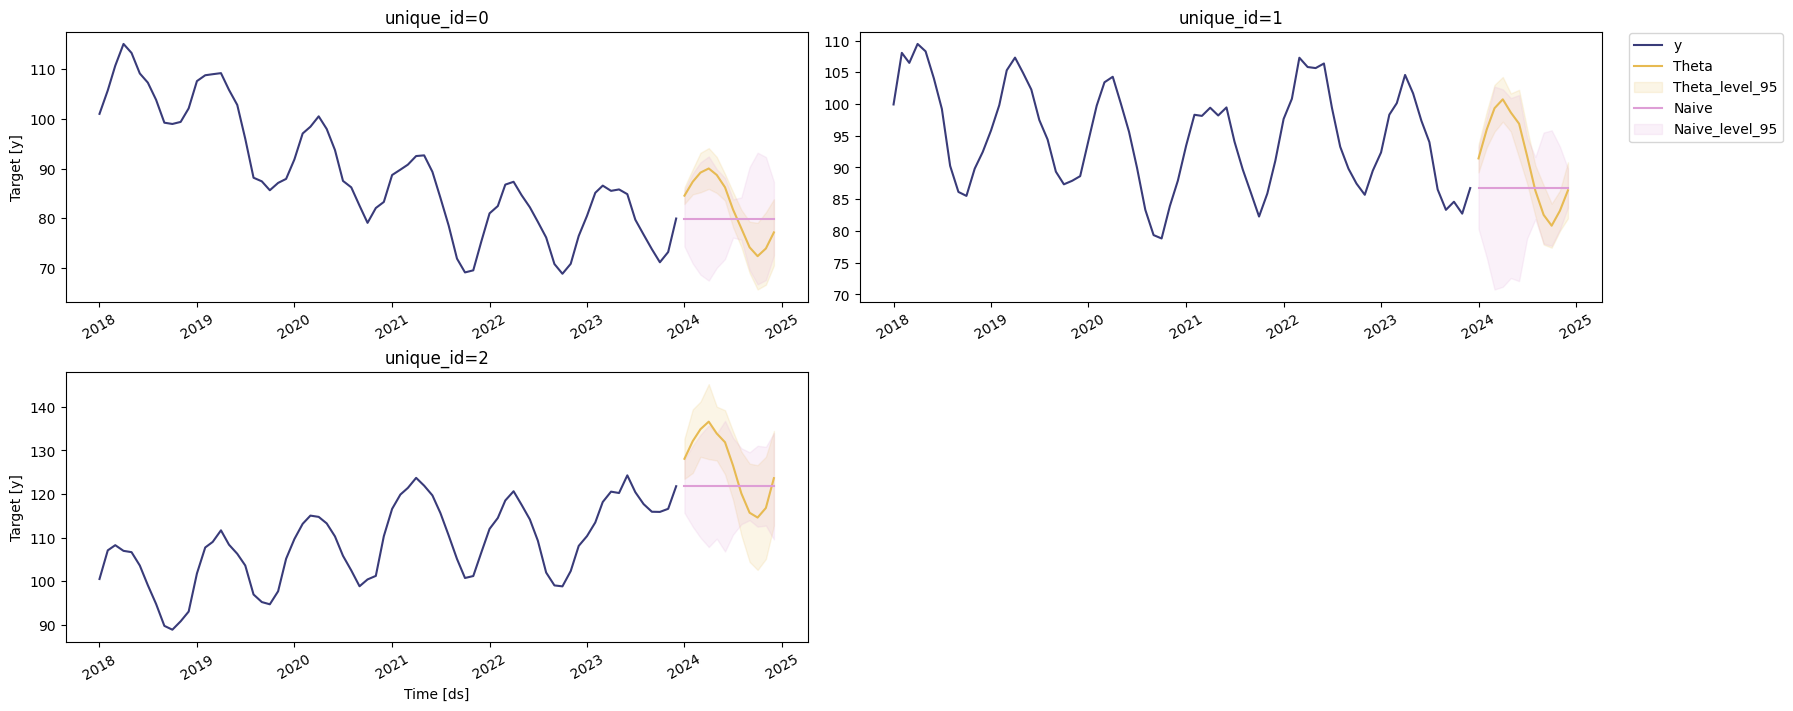

In [3]:
horizon = 12
sf = StatsForecast(
    models=[
        SktimeModel(ThetaForecaster(sp=12), alias='Theta'),
        SktimeModel(NaiveForecaster(), alias='Naive'),
    ],
    freq='MS',
)
preds = sf.forecast(
    df=train,
    h=horizon,
    prediction_intervals=ConformalIntervals(n_windows=4, h=horizon),
    level=[95],
)
plot_series(train, preds, level=[95], palette='tab20b', max_ids=3)

## 2. Exogenous regressors with PolynomialTrendForecaster

sktime's `PolynomialTrendForecaster` can use exogenous variables: pass `X` in `fit` and future `X` in `predict`. With `SktimeModel`, include exogenous columns in your training dataframe and pass `X_df` (future exogenous) to `forecast`.

In [4]:
# Training data: add an exogenous variable (e.g. time trend)
train_exog = train.copy()
train_exog['trend'] = np.tile(np.arange(len_series), n_series)

# Future exogenous: same columns for the forecast horizon (required by statsforecast)
next_start = train['ds'].max() + pd.offsets.MonthBegin(1)
future_dates = pd.date_range(start=next_start, periods=horizon, freq='MS')
X_future_list = []
for i in range(n_series):
    X_future_list.append(pd.DataFrame({
        'unique_id': str(i),
        'ds': future_dates,
        'trend': np.arange(len_series, len_series + horizon),
    }))
X_df = pd.concat(X_future_list, ignore_index=True)
X_df.head()

,unique_id,ds,trend
0,0,2024-01-01,72
1,0,2024-02-01,73
2,0,2024-03-01,74
3,0,2024-04-01,75
4,0,2024-05-01,76


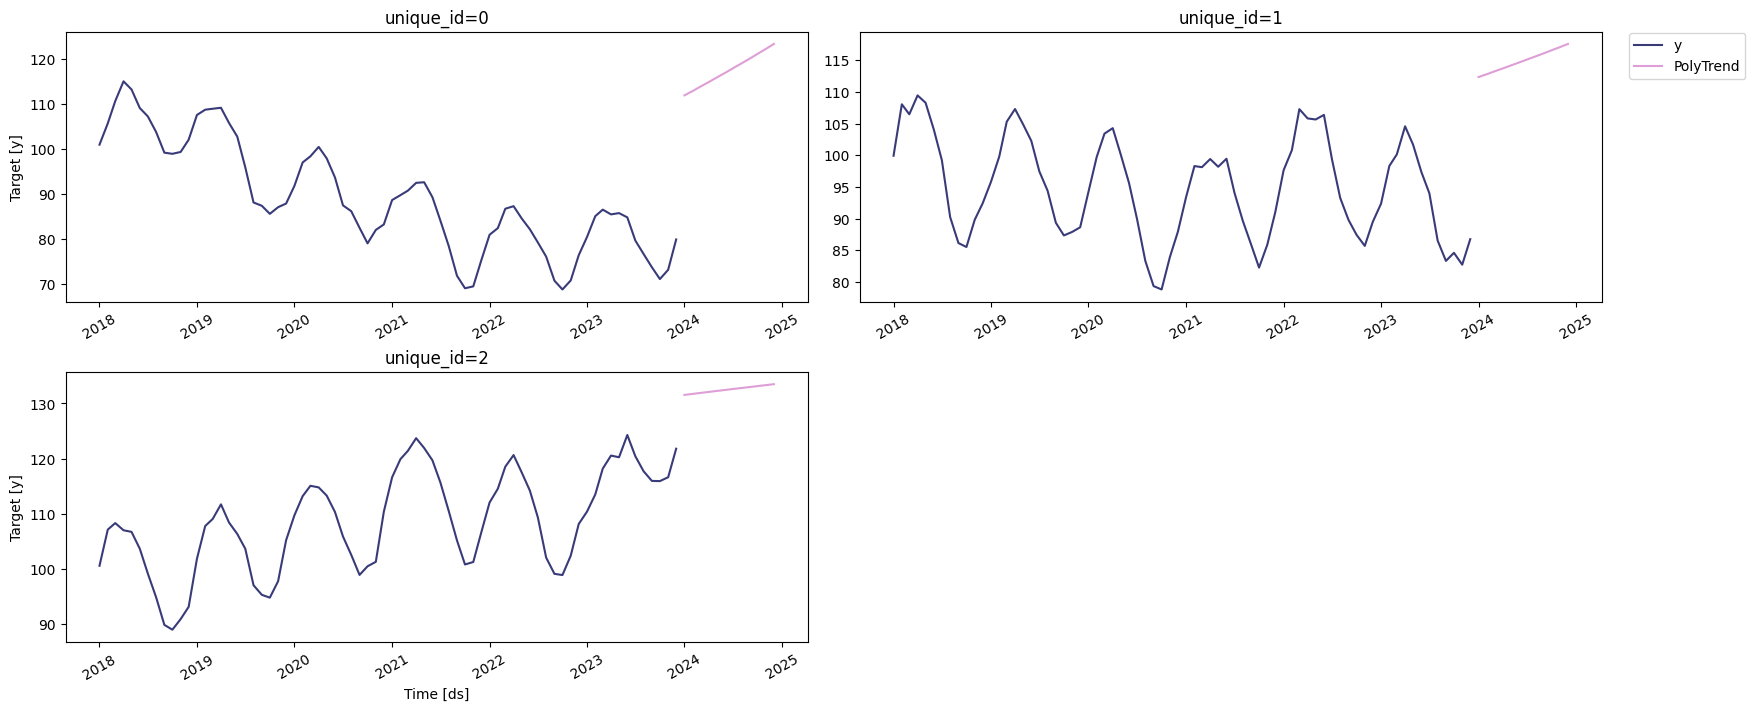

In [5]:
sf_exog = StatsForecast(
    models=[
        SktimeModel(PolynomialTrendForecaster(degree=2), alias='PolyTrend'),
    ],
    freq='MS',
)
preds_exog = sf_exog.forecast(df=train_exog, h=horizon, X_df=X_df)
plot_series(train_exog, preds_exog, palette='tab20b', max_ids=3)